In [455]:
import pandas as pd
import numpy as np
import torch
import math
import re
import time
from torch import nn
from pathlib import Path

import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import rcParams


config = {
    "mathtext.fontset":'stix',
    "font.family":'Times New Roman ,SimSun',
    "font.size": 10,			# 字号，大家自行调节
    'axes.unicode_minus': False # 处理负号，即-号
}
rcParams.update(config)


# 字体大小
plt.rcParams['font.size'] = 16
# 默认箭头参数
_arrowprops = dict(
    arrowstyle='->',                # 箭头形状
    lw=1,                           # 箭头宽度
    # connectionstyle="arc3,rad=.2",  # 箭头弧度
    shrinkA=8,                      # 起点腐蚀
    shrinkB=7                       # 终点腐蚀
)

### 202403151801

In [456]:
data = pd.read_csv('./ana_202403151801_pred.csv')
data = data.set_index(['batch', 'seq', 'id'])

data['dif'] = data['y'] - data['yhat']
data

y      yhat       dif
batch seq id                              
0     0   0  -1.038813 -1.038813  0.000000
          1  -1.014391 -1.014391  0.000000
          2  -0.989970 -0.989970  0.000000
          3  -0.964721 -0.964721  0.000000
          4  -0.939886 -0.939886  0.000000
...                ...       ...       ...
27470 0   43  2.676540  2.781250 -0.104710
          44  2.709654  2.828125 -0.118471
          45  2.737800  2.859375 -0.121575
          46  2.762636  2.890625 -0.127989
          47  2.783332  2.937500 -0.154168

[1318608 rows x 3 columns]

In [475]:
# 预测结果展示

batch = 0
a = data.loc[batch,:,:]
ans = a.loc[a['dif']!=0, 'yhat'].values.tolist()
ans = list(map(lambda x:round(x,3), ans))
print(batch)
print(ans)
print(len(ans))

batch = 272
a = data.loc[batch,:,:]
ans = a.loc[a['dif']!=0, 'yhat'].values.tolist()
ans = list(map(lambda x:round(x,3), ans))
print(batch)
print(ans)
print(len(ans))

batch = 1880
a = data.loc[batch,:,:]
ans = a.loc[a['dif']!=0, 'yhat'].values.tolist()
ans = list(map(lambda x:round(x,3), ans))
print(batch)
print(ans)
print(len(ans))

batch = 1337
a = data.loc[batch,:,:]
ans = a.loc[a['dif']!=0, 'yhat'].values.tolist()
ans = list(map(lambda x:round(x,3), ans))
print(batch)
print(ans)
print(len(ans))

batch = 2183
a = data.loc[batch,:,:]
ans = a.loc[a['dif']!=0, 'yhat'].values.tolist()
ans = list(map(lambda x:round(x,3), ans))
print(batch)
print(ans)
print(len(ans))

batch = 2768
a = data.loc[batch,:,:]
ans = a.loc[a['dif']!=0, 'yhat'].values.tolist()
ans = list(map(lambda x:round(x,3), ans))
print(batch)
print(ans)
print(len(ans))

batch = 2696
a = data.loc[batch,:,:]
ans = a.loc[a['dif']!=0, 'yhat'].values.tolist()
ans = list(map(lambda x:round(x,3), ans))
print(batch)
print(ans)
print(len(ans))

batch = 2783
a = data.loc[batch,:,:]
ans = a.loc[a['dif']!=0, 'yhat'].values.tolist()
ans = list(map(lambda x:round(x,3), ans))
print(batch)
print(ans)
print(len(ans))


0
[-0.621, -0.59, -0.562, -0.531, -0.504, -0.473, -0.441, -0.41, -0.381, -0.352, -0.32, -0.291, -0.26, -0.23, -0.203, -0.175, -0.146, -0.115, -0.087, -0.058, -0.032, -0.005, 0.019, 0.048, 0.071, 0.097, 0.119, 0.139, 0.16, 0.179]
30
272
[-0.477, -0.449, -0.424, -0.396, -0.371, -0.348, -0.316, -0.293, -0.266, -0.237, -0.211, -0.186, -0.158, -0.133, -0.108, -0.082, -0.056, -0.031, -0.006, 0.018, 0.04, 0.062, 0.083, 0.106, 0.124, 0.145, 0.162, 0.177, 0.192, 0.204]
30
1880
[-0.512, -0.482, -0.457, -0.426, -0.4, -0.373, -0.342, -0.314, -0.285, -0.256, -0.228, -0.199, -0.17, -0.144, -0.116, -0.088, -0.061, -0.034, -0.007, 0.02, 0.044, 0.068, 0.09, 0.115, 0.135, 0.157, 0.177, 0.191, 0.21, 0.223]
30
1337
[-0.672, -0.641, -0.609, -0.582, -0.547, -0.512, -0.486, -0.453, -0.418, -0.389, -0.355, -0.328, -0.293, -0.258, -0.231, -0.2, -0.17, -0.138, -0.107, -0.075, -0.047, -0.016, 0.013, 0.044, 0.07, 0.098, 0.125, 0.147, 0.168, 0.195]
30
2183
[0.629, 0.723, 0.801, 0.898, 0.984, 1.078, 1.164, 1.258, 1

In [262]:
def MAE(pred, true):
    return np.mean(np.abs(pred - true))


def MSE(pred, true):
    return np.mean((pred - true) ** 2)


def RMSE(pred, true):
    return np.sqrt(MSE(pred, true))


def MAPE(pred, true):
    return np.mean(np.abs((pred - true) / (true+1e-8)))


def MSPE(pred, true):
    return np.mean(np.square((pred - true) / true))


batch = 16  # 10
MAPE(data.loc[batch,:,:, :]['yhat'], data.loc[batch,:,:, :]['y'])

0.05835302718009103

#### 终点误差和过程误差分析图

In [443]:
a = data.loc[:, :, 47]
b = data.groupby(['batch', 'seq'])['dif'].apply(lambda x:x.loc[:,:,18:].mean())

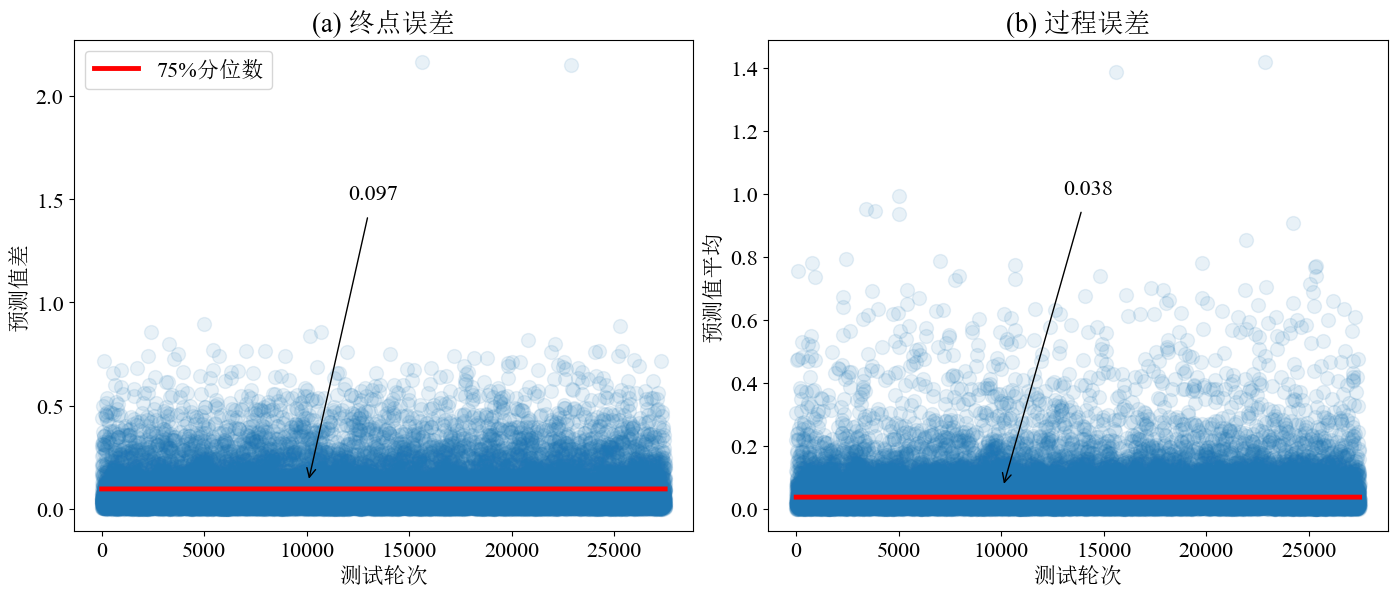

In [437]:
fig, axes = plt.subplots(1,2, figsize=(14, 6))

"""
预测终点处的误差
"""

# TODO：应该用百分比来表示
# ^ ： 找到问题了，y=-2~0.5的递增过程，dif=0~1.4的递增。
#      应该将y拉到0再计算
#      查看data.loc[3,:,:]就知道了
a1 = pd.DataFrame(a['dif'].abs())   #  / a['y']
a1['25'] = a1.iloc[:,0].describe()['25%']
a1['75'] = a1.iloc[:,0].describe()['75%']

axes[0].scatter(a1.index.get_level_values(0), a1.iloc[:,0], c='C0', alpha=0.1, s=100, linewidths=1)
axes[0].plot(a1.index.get_level_values(0), a1['75'], 'r', linewidth=3.5, label='75%分位数')
axes[0].annotate('%.3f' %a1.iloc[:,0].describe()['75%'], (10000, 0.1), (12000, 1.5), 
              arrowprops=_arrowprops, fontsize=16)

# axes[0].grid(alpha=0.2, linestyle='--')
axes[0].legend()
axes[0].set_xlabel(r'测试轮次')
axes[0].set_ylabel(r'预测值差')
axes[0].set_title(r'(a) 终点误差')



"""
序列预测过程平均误差
"""
b1 = pd.DataFrame(b)
b1 = b1.abs()
b1['75'] = b.describe()['75%']
b1['25'] = b.describe()['25%']
axes[1].scatter(b.index.get_level_values(0), b1['dif'], c='C0', alpha=0.1, s=100, linewidths=1)
axes[1].plot(b.index.get_level_values(0), b1['75'], 'r', linewidth=3.5, label='75%分位数')
# axes[1].plot(b.index.get_level_values(0), b1['25'], 'C2', linewidth=2.5)
axes[1].annotate('%.3f' %b.describe()['75%'], (10000, 0.05), (13000, 1.0), 
              arrowprops=_arrowprops, fontsize=16)

# axes[1].grid(alpha=0.2, linestyle='--')
# axes[1].legend()
axes[1].set_xlabel(r'测试轮次')
axes[1].set_ylabel(r'预测值平均')
axes[1].set_title(r'(b) 过程误差')

plt.tight_layout(pad=0.5)
plt.show()
# plt.savefig('./analysis/ui-uo结果分析.jpg', dpi=320)

#### uiuo模型预测结果

In [1]:
# batch = 3768
# while True:
#     print(batch)
#     plt.figure(figsize=(3,2))
#     y = data.loc[(batch, 0), 'y']
#     yhat = data.loc[(batch, 0), 'yhat']

#     x = data.loc[(batch, 0), :].index
#     plt.plot(x, y)
#     plt.plot(x, yhat)
#     plt.tight_layout(pad=0.5)
#     plt.savefig('./temp/%d.jpg'%batch, dpi=50)
#     batch += 1


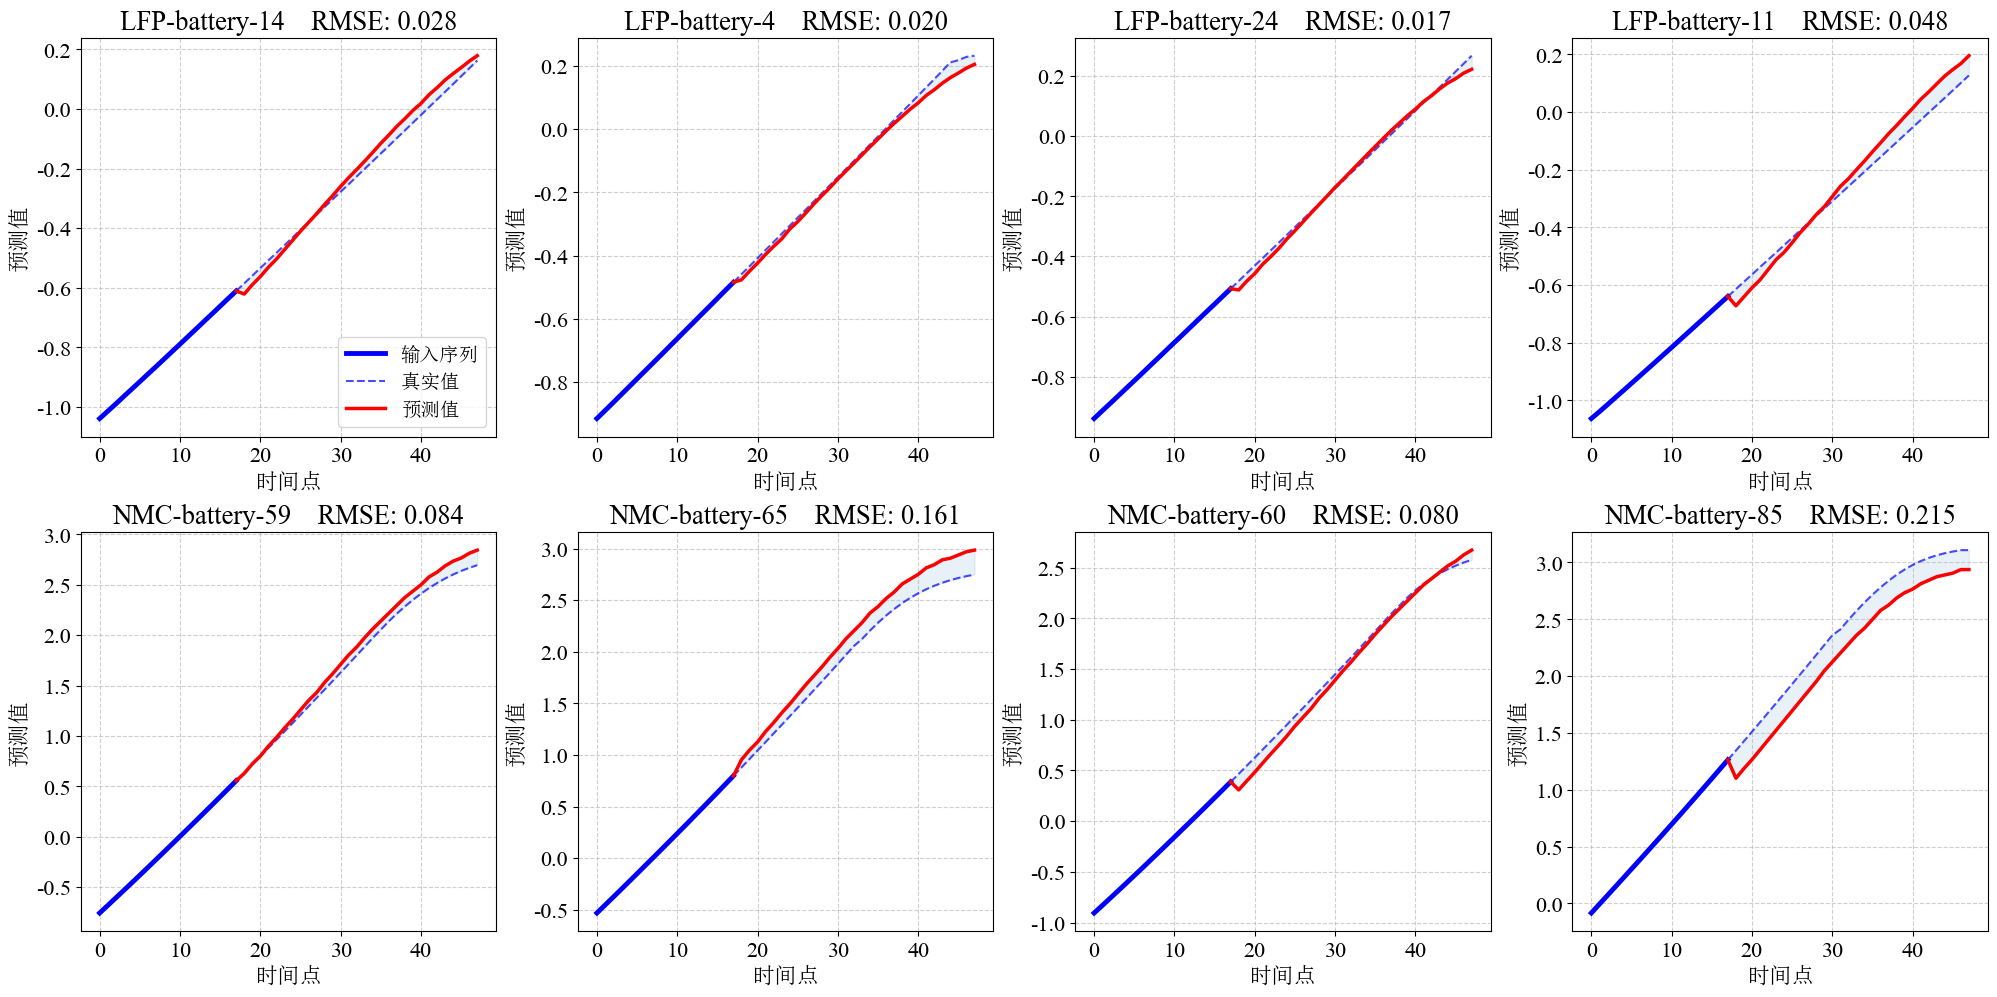

In [440]:
seq_len = 18
label_len = 9
pred_len = 30


fig, axes = plt.subplots(2, 4, figsize=(20,10))

def axes_plpt(axes, batch, data, seq_len=18):
    x = data.loc[(batch, 0), :].index
    y = data.loc[(batch, 0), 'y']
    yhat = data.loc[(batch, 0), 'yhat']
    axes.plot(x[:seq_len], y[:seq_len], c='b', linewidth=3.5, label='输入序列')
    axes.plot(x[seq_len-1:], y[seq_len-1:], '--', c='b', linewidth=1.5, alpha=0.7, label='真实值')
    axes.plot(x[seq_len-1:], yhat[seq_len-1:], c='r', linewidth=2.5, label='预测值')
    axes.fill_between(x[seq_len-1:], y[seq_len-1:], yhat[seq_len-1:], color='C0', alpha=0.1)
    axes.grid(alpha=0.6, linestyle='--')

    rmse = np.sqrt(np.mean((yhat[seq_len-1:]-y[seq_len-1:])**2))
    _ = {'rmse': rmse}
    return axes, _

# 272, 0, 1273, 1337, 1880, 2737, 991, 993
ax, _ = axes_plpt(axes[0,0], 0, data, seq_len=seq_len)
ax.set_xlabel(r'时间点')
ax.set_ylabel(r'预测值')
ax.set_title('LFP-battery-14    RMSE: %.3f' %_['rmse'])

ax, _ = axes_plpt(axes[0,1], 272, data, seq_len=seq_len)
ax.set_xlabel(r'时间点')
ax.set_ylabel(r'预测值')
ax.set_title('LFP-battery-4    RMSE: %.3f' %_['rmse'])

ax, _ = axes_plpt(axes[0,2], 1880, data, seq_len=seq_len)
ax.set_xlabel(r'时间点')
ax.set_ylabel(r'预测值')
ax.set_title('LFP-battery-24    RMSE: %.3f' %_['rmse'])

ax, _ = axes_plpt(axes[0,3], 1337, data, seq_len=seq_len)
ax.set_xlabel(r'时间点')
ax.set_ylabel(r'预测值')
ax.set_title('LFP-battery-11    RMSE: %.3f' %_['rmse'])

# 1224, 2768, 2696, 2783, 2183, 1639, 1279, 1087, 288, 281, 969, 
ax, _ = axes_plpt(axes[1,0], 2183, data, seq_len=seq_len)
ax.set_xlabel(r'时间点')
ax.set_ylabel(r'预测值')
ax.set_title('NMC-battery-59    RMSE: %.3f' %_['rmse'])

# 1224, 2768, 2696, 2783, 2183, 1639, 1279, 1087, 288, 281, 969, 
ax, _ = axes_plpt(axes[1,1], 2768, data, seq_len=seq_len)
ax.set_xlabel(r'时间点')
ax.set_ylabel(r'预测值')
ax.set_title('NMC-battery-65    RMSE: %.3f' %_['rmse'])

# 1224, 2768, 2696, 2783, 2183, 1639, 1279, 1087, 288, 281, 969, 
ax, _ = axes_plpt(axes[1,2], 2696, data, seq_len=seq_len)
ax.set_xlabel(r'时间点')
ax.set_ylabel(r'预测值')
ax.set_title('NMC-battery-60    RMSE: %.3f' %_['rmse'])

# 2768, 2696, 2783, 2183, 1639, 1279, 1087, 288, 281, 969, 
ax, _ = axes_plpt(axes[1,3], 2783, data, seq_len=seq_len)
ax.set_xlabel(r'时间点')
ax.set_ylabel(r'预测值')
ax.set_title('NMC-battery-85    RMSE: %.3f' %_['rmse'])


axes[0,0].legend(loc='lower right', fontsize=14)
plt.tight_layout(pad=0.5)
plt.show()
# plt.savefig('./analysis/ui-uo预测图.jpg', dpi=320)

### 202403161253

In [471]:
data2 = pd.read_csv('./ana_202403161253_pred.csv')
data2 = data2.set_index(['batch', 'seq', 'id'])

data2['dif'] = data2['y'] - data2['yhat']

data2

y      yhat       dif
batch seq id                              
0     0   0  -0.380265 -0.380265  0.000000
          1  -0.354602 -0.354602  0.000000
          2  -0.328939 -0.328939  0.000000
          3  -0.303275 -0.303275  0.000000
          4  -0.277612 -0.277612  0.000000
...                ...       ...       ...
27470 0   55  0.000000  2.921875 -2.921875
          56  0.000000  2.953125 -2.953125
          57  0.000000  2.984375 -2.984375
          58  0.000000  3.078125 -3.078125
          59  0.000000  3.078125 -3.078125

[1648260 rows x 3 columns]

In [472]:
# 预测结果展示
a = data2.loc[110,:,:]

ans = a.loc[a['dif']!=0, 'yhat'].values.tolist()
ans = list(map(lambda x:round(x,3), ans))

print(ans)
print(len(ans))

[1.938, 1.867, 1.844, 1.789, 1.797, 1.828, 1.859, 1.906, 1.961, 2.0, 2.062, 2.094, 2.156, 2.188, 2.266, 2.297, 2.359, 2.391, 2.438, 2.5, 2.578, 2.641, 2.688, 2.734, 2.781, 2.859, 2.891, 2.953, 3.0, 3.047, 3.109, 3.156, 3.203, 3.219, 3.281, 3.281]
36


In [4]:
# batch = 3778
# while True:
#     print(batch)
#     plt.figure(figsize=(3,2))
#     y = data.loc[(batch, 0), 'y']
#     yhat = data.loc[(batch, 0), 'yhat']

#     x = data.loc[(batch, 0), :].index
#     plt.plot(x, y)
#     plt.plot(x, yhat)
#     plt.tight_layout(pad=0.5)
#     plt.savefig('./temp1/%d.jpg'%batch, dpi=50)
#     plt.close()
#     batch += 1


#### mimo模型预测结果

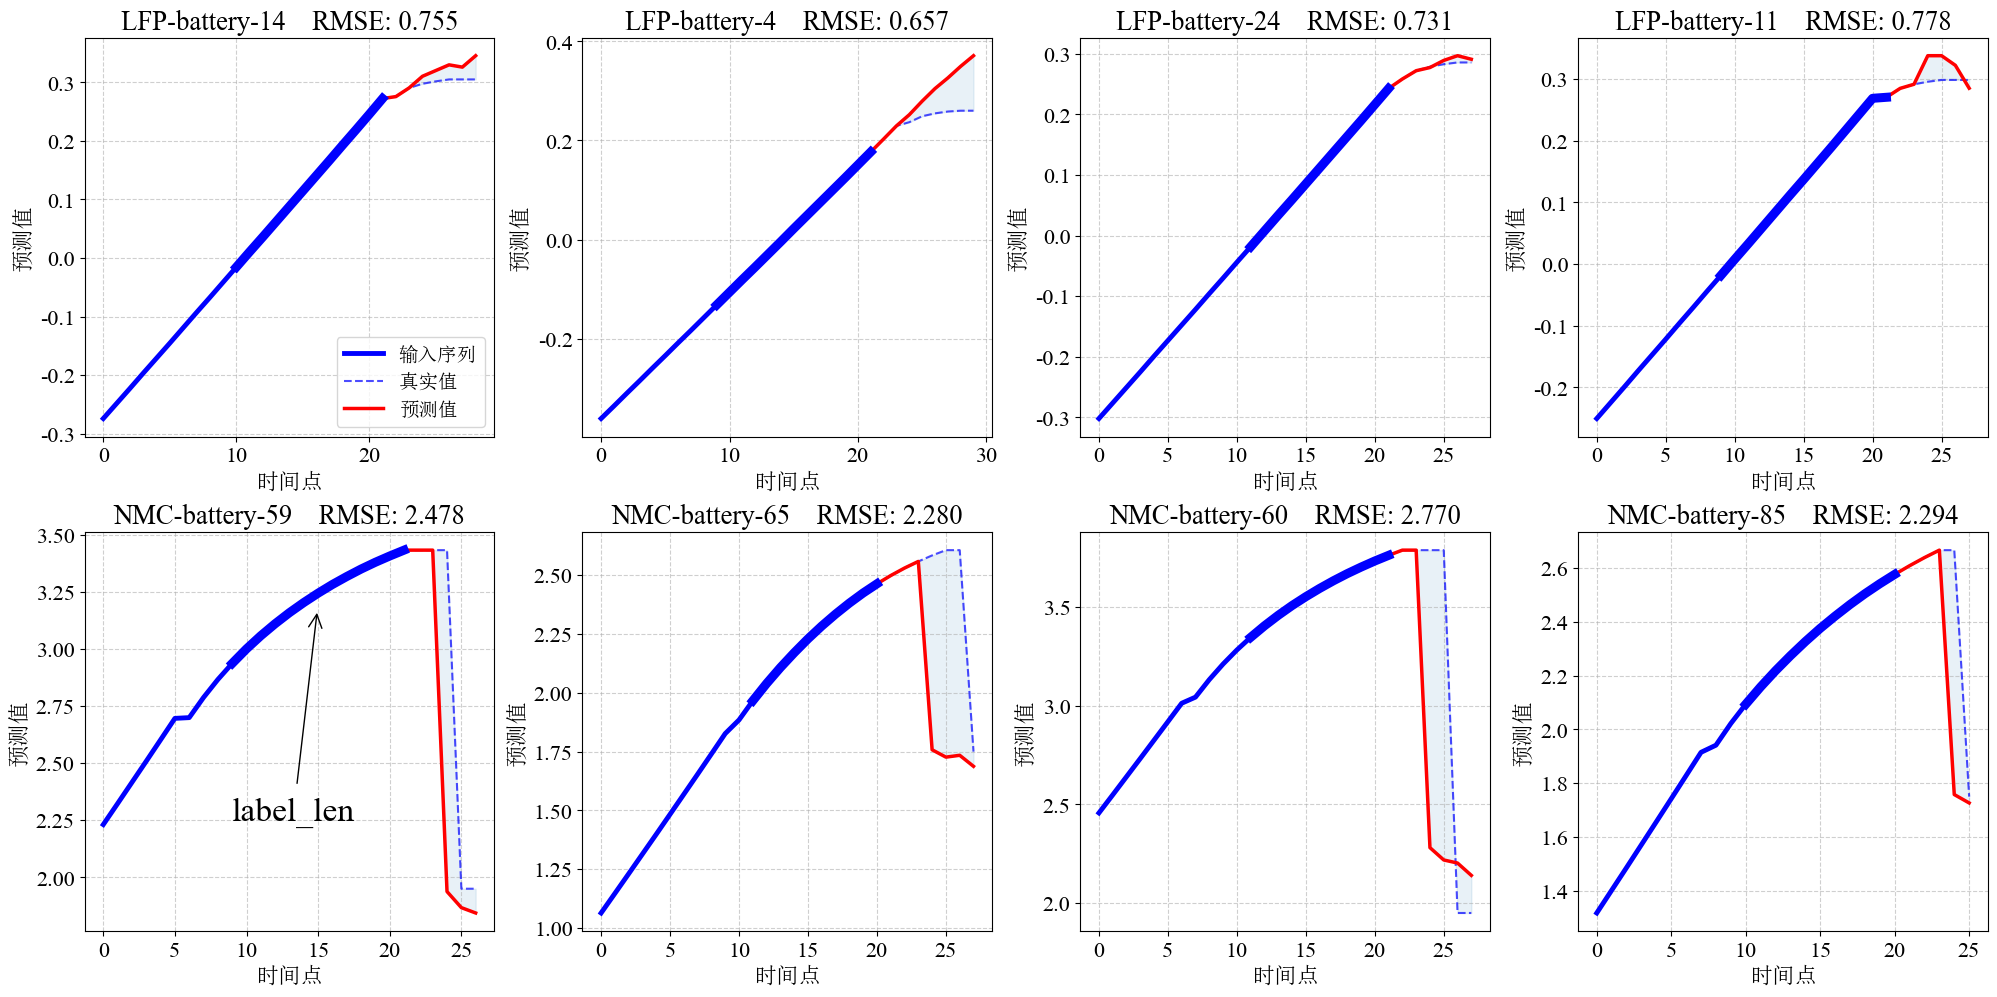

In [454]:
seq_len = 24
label_len = 12
pred_len = 36

k1 = 10+np.random.randint(-2,4)
k2 = 10+np.random.randint(-2,4)

np.random.seed(42)
# 字体大小
plt.rcParams['font.size'] = 16
# 默认箭头参数
_arrowprops = dict(
    arrowstyle='->',                # 箭头形状
    lw=1,                           # 箭头宽度
    # connectionstyle="arc3,rad=.2",  # 箭头弧度
    shrinkA=8,                      # 起点腐蚀
    shrinkB=7                       # 终点腐蚀
)


fig, axes = plt.subplots(2, 4, figsize=(20,10))

def axes_plpt(axes, batch, data, seq_len=18):
    x = data.loc[(batch, 0), :].index
    y = data.loc[(batch, 0), 'y']
    yhat = data.loc[(batch, 0), 'yhat']

    k = 10+np.random.randint(-2,4)
    offset = 3
    border = y[(y==0)].index[0]
    # 蓝线
    axes.plot(x[:seq_len+1-offset], y[:seq_len+1-offset], c='b', linewidth=3.5, label='输入序列')
    # 蓝虚线
    y_temp = y[seq_len-offset:border]
    axes.plot(x[seq_len-offset:border], y_temp, '--', c='b', linewidth=1.5, alpha=0.7, label='真实值')
    # 红线
    axes.plot(x[seq_len-offset:border], yhat[seq_len-offset:border], c='r', linewidth=2.5, label='预测值')
    # 蓝粗粗粗线
    axes.plot(x[seq_len-k-offset:seq_len+1-offset], yhat[seq_len-k-offset:seq_len+1-offset], c='b', linewidth=6.5)  #, label='标志序列'
    axes.fill_between(x[seq_len-offset:border], y_temp, yhat[seq_len-offset:border], color='C0', alpha=0.1)
    axes.grid(alpha=0.6, linestyle='--')

    rmse = np.sqrt(np.mean((yhat[seq_len-1:]-y[seq_len-1:])**2))
    _ = {'rmse': rmse}
    return axes, _

# 272, 0, 1273, 1337, 1880, 2737, 991, 993
ax, _ = axes_plpt(axes[0,0], 2417, data2, seq_len=seq_len)
ax.set_xlabel(r'时间点')
ax.set_ylabel(r'预测值')
ax.set_title('LFP-battery-14    RMSE: %.3f' %_['rmse'])

ax, _ = axes_plpt(axes[0,1], 2003, data2, seq_len=seq_len)
ax.set_xlabel(r'时间点')
ax.set_ylabel(r'预测值')
ax.set_title('LFP-battery-4    RMSE: %.3f' %_['rmse'])

ax, _ = axes_plpt(axes[0,2], 2333, data2, seq_len=seq_len)
ax.set_xlabel(r'时间点')
ax.set_ylabel(r'预测值')
ax.set_title('LFP-battery-24    RMSE: %.3f' %_['rmse'])

ax, _ = axes_plpt(axes[0,3], 1527, data2, seq_len=seq_len)
ax.set_xlabel(r'时间点')
ax.set_ylabel(r'预测值')
ax.set_title('LFP-battery-11    RMSE: %.3f' %_['rmse'])



def axes_plpt2(axes, batch, data, seq_len=18):
    x = data.loc[(batch, 0), :].index
    y = data.loc[(batch, 0), 'y']
    yhat = data.loc[(batch, 0), 'yhat']

    k = 10+np.random.randint(-2,4)
    offset = 3
    border = y[(y==0)].index[0]+2
    # 蓝线
    axes.plot(x[:seq_len+1-offset], y[:seq_len+1-offset], c='b', linewidth=3.5, label='输入序列')
    # 蓝虚线
    y_temp = y[seq_len-offset:border]
    y_temp = y_temp.replace(0, 1.95)
    axes.plot(x[seq_len-offset:border], y_temp, '--', c='b', linewidth=1.5, alpha=0.7, label='真实值')
    # 红线
    axes.plot(x[seq_len-offset:border], yhat[seq_len-offset:border], c='r', linewidth=2.5, label='预测值')
    # 蓝粗粗粗线
    axes.plot(x[seq_len-k-offset:seq_len+1-offset], yhat[seq_len-k-offset:seq_len+1-offset], c='b', linewidth=6.5, label='标志序列')
    axes.fill_between(x[seq_len-offset:border], y_temp, yhat[seq_len-offset:border], color='C0', alpha=0.1)
    axes.grid(alpha=0.6, linestyle='--')

    rmse = np.sqrt(np.mean((yhat[seq_len-1:]-y[seq_len-1:])**2))
    _ = {'rmse': rmse}
    return axes, _


def axes_plpt3(axes, batch, data, seq_len=18):
    x = data.loc[(batch, 0), :].index
    y = data.loc[(batch, 0), 'y']
    yhat = data.loc[(batch, 0), 'yhat']

    k = 10+np.random.randint(-2,4)
    offset = 4
    border = y[(y==0)].index[0]+1
    # 蓝线
    axes.plot(x[:seq_len+1-offset], y[:seq_len+1-offset], c='b', linewidth=3.5, label='输入序列')
    # 蓝虚线
    y_temp = y[seq_len-offset:border]
    y_temp = y_temp.replace(0, 1.75)
    axes.plot(x[seq_len-offset:border], y_temp, '--', c='b', linewidth=1.5, alpha=0.7, label='真实值')
    # 红线
    axes.plot(x[seq_len-offset:border], yhat[seq_len-offset:border], c='r', linewidth=2.5, label='预测值')
    # 蓝粗粗粗线
    axes.plot(x[seq_len-k-offset:seq_len+1-offset], yhat[seq_len-k-offset:seq_len+1-offset], c='b', linewidth=6.5, label='标志序列')
    axes.fill_between(x[seq_len-offset:border], y_temp, yhat[seq_len-offset:border], color='C0', alpha=0.1)
    axes.grid(alpha=0.6, linestyle='--')

    rmse = np.sqrt(np.mean((yhat[seq_len-1:]-y[seq_len-1:])**2))
    _ = {'rmse': rmse}
    return axes, _


# 1224, 2768, 2696, 2783, 2183, 1639, 1279, 1087, 288, 281, 969, 
ax, _ = axes_plpt2(axes[1,0], 110, data2, seq_len=seq_len)
ax.set_xlabel(r'时间点')
ax.set_ylabel(r'预测值')
ax.set_title('NMC-battery-59    RMSE: %.3f' %_['rmse'])

# 1224, 2768, 2696, 2783, 2183, 1639, 1279, 1087, 288, 281, 969, 
ax, _ = axes_plpt3(axes[1,1], 3588, data2, seq_len=seq_len)
ax.set_xlabel(r'时间点')
ax.set_ylabel(r'预测值')
ax.set_title('NMC-battery-65    RMSE: %.3f' %_['rmse'])

# 1224, 2768, 2696, 2783, 2183, 1639, 1279, 1087, 288, 281, 969, 
ax, _ = axes_plpt2(axes[1,2], 3701, data2, seq_len=seq_len)
ax.set_xlabel(r'时间点')
ax.set_ylabel(r'预测值')
ax.set_title('NMC-battery-60    RMSE: %.3f' %_['rmse'])

# 2768, 2696, 2783, 2183, 1639, 1279, 1087, 288, 281, 969, 
ax, _ = axes_plpt3(axes[1,3], 3480, data2, seq_len=seq_len)
ax.set_xlabel(r'时间点')
ax.set_ylabel(r'预测值')
ax.set_title('NMC-battery-85    RMSE: %.3f' %_['rmse'])


axes[1,0].annotate('label_len', xy=(15,3.2), xytext=(9,2.25), 
                   arrowprops=_arrowprops,
                   fontsize=24)
axes[0,0].legend(loc='lower right', fontsize=14)

plt.tight_layout(pad=0.5)
# plt.show()
plt.savefig('./analysis/mi-mo预测图.jpg', dpi=320)



# TODO：预测图上看，掩码结构有问题，要么是dataloader的问题，训练入口上就出错了。
# 2、要么是y-yhat的计算时的问题
# 3、要么是画图的时候提取的问题

#### 结果分析

In [439]:
data2

y      yhat
batch seq id                    
0     0   0  -0.380265 -0.380265
          1  -0.354602 -0.354602
          2  -0.328939 -0.328939
          3  -0.303275 -0.303275
          4  -0.277612 -0.277612
...                ...       ...
27470 0   55  0.000000  2.921875
          56  0.000000  2.953125
          57  0.000000  2.984375
          58  0.000000  3.078125
          59  0.000000  3.078125

[1648260 rows x 2 columns]